# 1. Setup

## 1.1. Import statements

In [1]:
%matplotlib inline

In [2]:
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'backend:cudaMallocAsync'

print(os.environ.get('PYTORCH_CUDA_ALLOC_CONF'))

backend:cudaMallocAsync


In [3]:
import torch
import torch.nn as nn
import time
import gc
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast, GradScaler
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

## 1.2. Device configuration

In [4]:
def get_device() -> torch.device:
    """Get the best available device for PyTorch."""
    if torch.cuda.is_available():
        device = "cuda"

        # The flag below controls whether to allow TF32 on matmul.
        torch.backends.cuda.matmul.allow_tf32 = True
        # The flag below controls whether to allow TF32 on cuDNN.
        torch.backends.cudnn.allow_tf32 = True

        # Print GPU info
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
        
        # Set up GPU memory management
        memory_limit_mb = 4095.5  # Adjust as needed

        total_memory = torch.cuda.get_device_properties(0).total_memory

        memory_limit = memory_limit_mb * 1024 ** 2
        memory_fraction = memory_limit / total_memory

        torch.cuda.set_per_process_memory_fraction(memory_fraction, device=0)

        print(f"Set GPU memory fraction to {memory_fraction:.2%}")

        # Ensure memory is allocated
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using Apple Silicon MPS device")
    else:
        device = "cpu"
        print("Using CPU device")
    
    return torch.device(device)

In [5]:
torch.set_float32_matmul_precision('high')
device = get_device()

Using CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Set GPU memory fraction to 100.00%


In [6]:
pin_memory = True if device.type == 'cuda' else False
pin_memory_device = 'cuda' if device.type == 'cuda' else ''

# 2. Load & transform data

## 2.1. Normalize the dataset

In [7]:
# First, create transforms without normalization to calculate dataset statistics
initial_transforms = v2.Compose([
    v2.Resize((384, 216)),# changed from v1
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
# Create temporary dataset to calculate mean and std
temp_dataset = ImageFolder(root='../data/merged_pool', transform=initial_transforms)

temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

In [9]:
calc_stats = True

if calc_stats:
    print(f"Computing dataset statistics using device: {device}")
    print(f"Number of images to process: {len(temp_dataset)}")

    channels_sum = torch.zeros(3, device=device)
    channels_sqrd_sum = torch.zeros(3, device=device)
    num_batches = 0
    start_time = time.time()

    for batch_idx, (data, _) in enumerate(tqdm(temp_loader, desc="Computing mean/std")):
        data = data.to(device, non_blocking=True)  # Add non_blocking=True
        with autocast(device.type):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1
        
        if batch_idx % 10 == 0:
            batch_time = time.time() - start_time
            print(f"\nProcessed {batch_idx * temp_loader.batch_size} images in {batch_time:.2f}s")

    mean = channels_sum / num_batches
    std = torch.sqrt((channels_sqrd_sum / num_batches) - (mean ** 2))

    mean = mean.cpu().tolist()
    std = std.cpu().tolist()

    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time:.2f} seconds")
    print(f"Dataset mean: {mean}")
    print(f"Dataset std: {std}")

    # Release memory
    del temp_dataset, temp_loader, channels_sum, channels_sqrd_sum, data
    gc.collect()

    torch.cuda.empty_cache()
else:
    mean=[0.35439860820770264, 0.35439860820770264, 0.35439860820770264]
    std=[0.20184797048568726, 0.20184797048568726, 0.20184797048568726]

Computing dataset statistics using device: cuda
Number of images to process: 12257


Computing mean/std:   1%|▎                                                   | 1/192 [00:03<10:40,  3.35s/it]


Processed 0 images in 3.36s


Computing mean/std:   4%|█▉                                                  | 7/192 [00:03<01:11,  2.58it/s]


Processed 640 images in 3.62s


Computing mean/std:  12%|██████                                             | 23/192 [00:06<00:33,  4.98it/s]


Processed 1280 images in 6.41s


Computing mean/std:  17%|████████▊                                          | 33/192 [00:09<00:38,  4.12it/s]


Processed 1920 images in 9.58s


Computing mean/std:  21%|██████████▉                                        | 41/192 [00:11<00:36,  4.18it/s]


Processed 2560 images in 11.83s


Computing mean/std:  26%|█████████████▎                                     | 50/192 [00:14<00:38,  3.70it/s]


Processed 3200 images in 14.50s


Computing mean/std:  32%|████████████████▏                                  | 61/192 [00:17<00:41,  3.13it/s]


Processed 3840 images in 17.63s


Computing mean/std:  37%|██████████████████▊                                | 71/192 [00:19<00:30,  4.00it/s]


Processed 4480 images in 19.95s


Computing mean/std:  42%|█████████████████████▎                             | 80/192 [00:22<00:30,  3.67it/s]


Processed 5120 images in 22.37s


Computing mean/std:  47%|████████████████████████▏                          | 91/192 [00:25<00:26,  3.83it/s]


Processed 5760 images in 25.09s


Computing mean/std:  53%|██████████████████████████▎                       | 101/192 [00:27<00:23,  3.87it/s]


Processed 6400 images in 27.90s


Computing mean/std:  58%|█████████████████████████████▏                    | 112/192 [00:30<00:13,  5.75it/s]


Processed 7040 images in 30.15s


Computing mean/std:  63%|███████████████████████████████▌                  | 121/192 [00:32<00:16,  4.28it/s]


Processed 7680 images in 32.67s


Computing mean/std:  68%|██████████████████████████████████                | 131/192 [00:35<00:15,  4.03it/s]


Processed 8320 images in 35.37s


Computing mean/std:  73%|████████████████████████████████████▍             | 140/192 [00:37<00:15,  3.36it/s]


Processed 8960 images in 37.83s


Computing mean/std:  79%|███████████████████████████████████████▎          | 151/192 [00:40<00:08,  4.56it/s]


Processed 9600 images in 40.31s


Computing mean/std:  83%|█████████████████████████████████████████▋        | 160/192 [00:43<00:10,  2.94it/s]


Processed 10240 images in 43.16s


Computing mean/std:  89%|████████████████████████████████████████████▎     | 170/192 [00:45<00:04,  4.45it/s]


Processed 10880 images in 45.29s


Computing mean/std:  94%|███████████████████████████████████████████████▏  | 181/192 [00:48<00:02,  3.91it/s]


Processed 11520 images in 48.41s


Computing mean/std: 100%|██████████████████████████████████████████████████| 192/192 [00:50<00:00,  3.78it/s]



Processed 12160 images in 50.81s

Total processing time: 50.90 seconds
Dataset mean: [0.5291024446487427, 0.5291024446487427, 0.5291024446487427]
Dataset std: [0.22500132024288177, 0.22500132024288177, 0.22500132024288177]


## 2.2. Define transforms

In [10]:
train_transforms = v2.Compose([
    v2.Resize((384, 216)), # changed from v1
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.1, contrast=0.1),
    v2.RandomPerspective(distortion_scale=0.3, p=0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [11]:
val_transforms = v2.Compose([
    v2.Resize((384, 216)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

# 3. Partition dataset

In [12]:
# Load the dataset with appropriate transforms
train_data = ImageFolder(root='../data/merged_pool', transform=train_transforms)

val_data = ImageFolder(root='../data/validation_pool', transform=val_transforms)

In [13]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)  

# 4. Building the convolutional neural network

In [14]:
# Input shape constants (changed from v1)
IMG_WIDTH = 384
IMG_HEIGHT = 216
IMG_CHANNELS = 3

In [15]:
class UnoSymbolClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1_block = nn.Sequential(
            nn.Conv2d(3, 8, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, 3, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv2_block = nn.Sequential(
            nn.Conv2d(16, 16, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv3_block = nn.Sequential(
            nn.Conv2d(32, 32, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv4_block = nn.Sequential(
            nn.Conv2d(64, 64, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(128 * (IMG_HEIGHT // 16) * (IMG_WIDTH // 16), 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fc4 = nn.Linear(64, 54)
        

    def forward(self, x) -> torch.utils.data.Dataset:
        x = self.conv1_block(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)
        x = self.conv4_block(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

## 4.2. Create the model

In [16]:
model = UnoSymbolClassifier()
model.to("cpu")

UnoSymbolClassifier(
  (conv1_block): Sequential(
    (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ReflectionPad2d((1, 1, 1, 1))
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ReflectionPad2d((1, 1, 1, 1))
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentu

In [17]:
summary(model, input_size=(64, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
UnoSymbolClassifier                      [64, 54]                  --
├─Sequential: 1-1                        [64, 16, 108, 192]        --
│    └─Conv2d: 2-1                       [64, 8, 216, 384]         32
│    └─BatchNorm2d: 2-2                  [64, 8, 216, 384]         16
│    └─ReLU: 2-3                         [64, 8, 216, 384]         --
│    └─ReflectionPad2d: 2-4              [64, 8, 218, 386]         --
│    └─Conv2d: 2-5                       [64, 16, 216, 384]        1,168
│    └─BatchNorm2d: 2-6                  [64, 16, 216, 384]        32
│    └─ReLU: 2-7                         [64, 16, 216, 384]        --
│    └─Conv2d: 2-8                       [64, 16, 216, 384]        272
│    └─BatchNorm2d: 2-9                  [64, 16, 216, 384]        32
│    └─ReLU: 2-10                        [64, 16, 216, 384]        --
│    └─MaxPool2d: 2-11                   [64, 16, 108, 192]        --
├─Sequentia

In [18]:
model.to(device, non_blocking=True)
model = torch.compile(model, backend="inductor")
torch.cuda.empty_cache()

# 5. Optimising model parameters

## 5.1. Learning parameters

In [19]:
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-6
EPOCHS = 40

## 5.2. Optimizer & cost function

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=True)

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

# 6. Training the model

## 6.1. Define train function

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    scaler = GradScaler()
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    training_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

        optimizer.zero_grad()

        with autocast(device.type):
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        training_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float32).sum().item()
        total += y.size(0)

        if batch % 100 == 0:
            loss_item = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = training_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

## 6.2. Define validate & test function

In [24]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

            with autocast(device.type):
                pred = model(X)
                loss = loss_fn(pred, y)

            test_loss += loss.item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float32).sum().item()
            total += y.size(0)

    avg_loss = test_loss / total
    accuracy = correct / total
    print(f"Avg loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%\n")

    return avg_loss, accuracy

## 6.3. Define overfitting function

In [25]:
def check_overfitting(train_loss, val_loss, train_acc, val_acc, threshold=0.1):
    loss_gap = abs(train_loss - val_loss)
    acc_gap = abs(train_acc - val_acc)
    
    is_overfitting = (loss_gap > threshold) and (train_acc > val_acc + threshold)
    
    if is_overfitting:
        print(f"Warning: Possible overfitting detected")
        print(f"Loss gap: {loss_gap:.4f}, Accuracy gap: {acc_gap:.4f}")
    
    return is_overfitting

## 6.4. Training loop

In [26]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_times = []

best_val_loss = float('inf')
best_model_metrics = None
stopped_early = False
is_overfitting = 0
patience = 300  # Number of epochs with no improvement after which training will be stopped
total_start_time = time.time()

In [ ]:
torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    epoch_start_time = time.time()

    train_loss, train_accuracy = train_loop(
        train_loader, model, loss_fn, optimizer)

    scheduler.step(train_loss)

    val_loss, val_accuracy = test_loop(val_loader, model, loss_fn)

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    epoch_time_min = epoch_time / 60
    print(f"Epoch {epoch+1} completed in {epoch_time_min:.2f} minutes")
    print(
        f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")

    # Increment overfitting counter if overfitting detected
    if check_overfitting(train_loss, val_loss, train_accuracy, val_accuracy):
        is_overfitting += 1
    else:
        is_overfitting = 0

    # Check all conditions
    accuracy_gap = abs(train_accuracy - val_accuracy)
    conditions_met = (
        train_loss >= 0.1 and
        val_loss >= 0.1 and
        train_accuracy <= 0.98 and
        val_accuracy <= 0.98 and
        accuracy_gap <= 0.07
    )

    # Save model if conditions are met and validation loss improved
    if conditions_met:
        best_val_loss = val_loss
        best_model_metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }
        torch.save(model.state_dict(),
                   '../data/models/best_symbol_classifier.pth')

    # Stop if overfitting persists for multiple epochs
    if is_overfitting >= patience:
        print(f"Early stopping triggered due to persistent overfitting.")
        stopped_early = True
        break

total_training_time = time.time() - total_start_time
avg_epoch_time = sum(epoch_times) / len(epoch_times) / 60
total_training_time_min = total_training_time / 60

# Save both models
torch.save(model.state_dict(), '../data/models/full_symbol_classifier.pth')

if best_model_metrics:
    print("\nBest model saved with metrics:")
    for key, value in best_model_metrics.items():
        print(f"{key}: {value}")

print(f"\nAverage time per epoch: {avg_epoch_time:.2f} minutes")
print(f"Total training time: {total_training_time_min:.2f} minutes")
print("\n-------------------------------\nDone!")

Epoch 1
-------------------------------
loss: 4.103973  [    0/12257]
loss: 3.365417  [ 6400/12257]
Avg loss: 2.891515, Accuracy: 9.9%

Epoch 1 completed in 124.50 seconds
Training Loss: 3.4597, Training Accuracy: 0.0813
Validation Loss: 2.8915, Validation Accuracy: 0.0995

Epoch 2
-------------------------------
loss: 2.850487  [    0/12257]
loss: 2.739761  [ 6400/12257]
Avg loss: 2.607383, Accuracy: 12.6%

Epoch 2 completed in 65.03 seconds
Training Loss: 2.7209, Training Accuracy: 0.1213
Validation Loss: 2.6074, Validation Accuracy: 0.1255

Epoch 3
-------------------------------
loss: 2.543602  [    0/12257]
loss: 2.607896  [ 6400/12257]
Avg loss: 2.419378, Accuracy: 17.6%

Epoch 3 completed in 64.97 seconds
Training Loss: 2.5090, Training Accuracy: 0.1661
Validation Loss: 2.4194, Validation Accuracy: 0.1763

Epoch 4
-------------------------------
loss: 2.300218  [    0/12257]
loss: 2.148818  [ 6400/12257]
Avg loss: 2.113582, Accuracy: 30.2%

Epoch 4 completed in 65.09 seconds
Tra

# 7. Plot model metrics

In [28]:
epochs_range = range(1, len(train_losses) + 1)

## 7.1. Loss graph

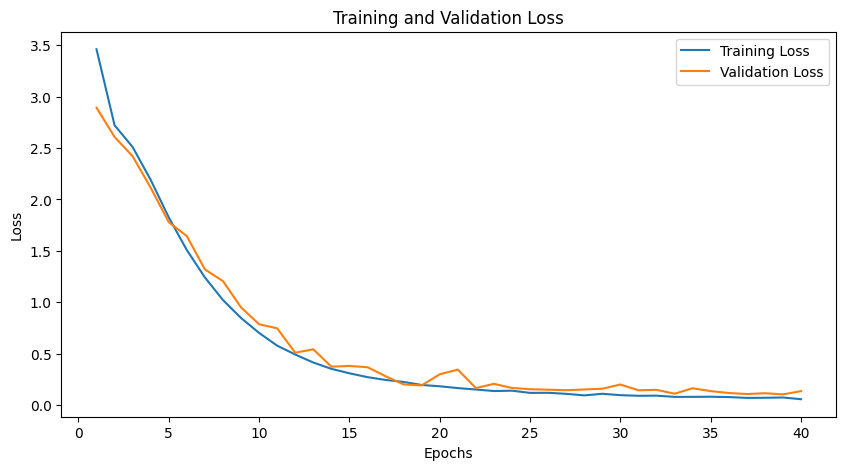

In [29]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 7.2. Accuracy graph

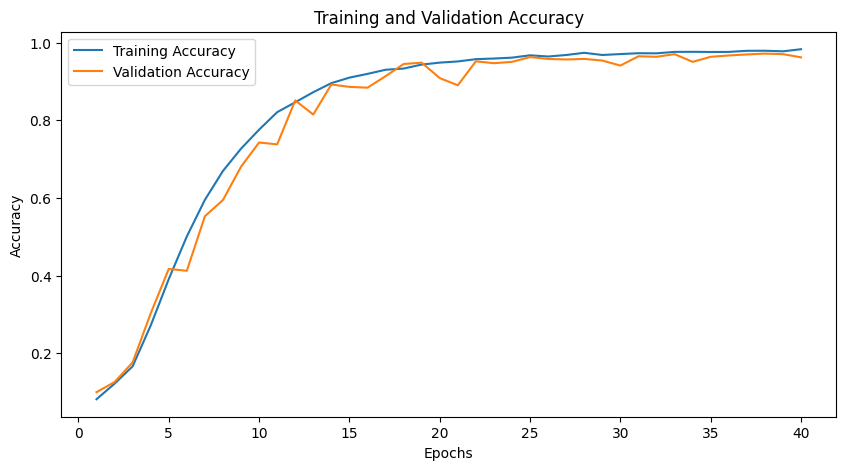

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## 7.3. Epoch duration graph

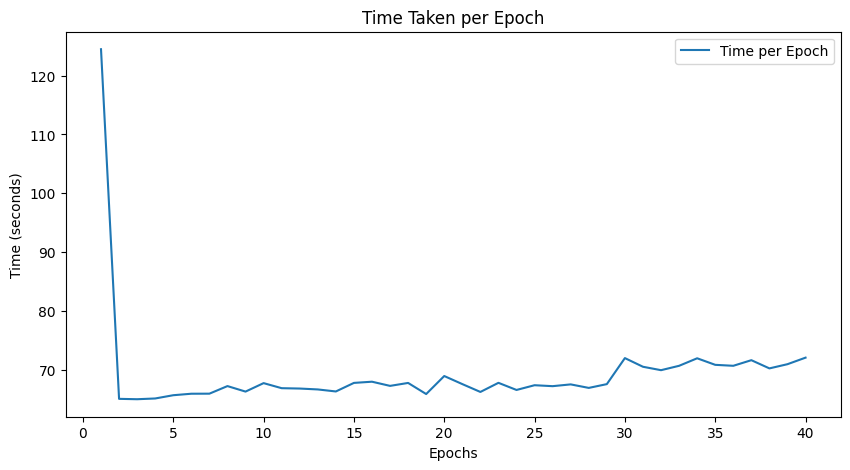

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, epoch_times, label='Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Time Taken per Epoch')
plt.legend()
plt.show()

# 8. Test the model

## 8.1. Create & load model

In [32]:
torch.cuda.empty_cache()

model = UnoSymbolClassifier()
model.to(device, non_blocking=True)
model = torch.compile(model, backend="inductor")

In [33]:
stopped_early = False

# Load the best model (if saved during early stopping)
if stopped_early:
    model.load_state_dict(torch.load('../data/models/best_symbol_classifier.pth', weights_only=True))
else:
    model.load_state_dict(torch.load('../data/models/full_symbol_classifier.pth', weights_only=True))

## 8.2. Test model

In [34]:
image_transform = v2.Compose([
    v2.Resize((512, 288)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [35]:
# Define class names
class_names = train_data.classes

In [36]:
# Specify the path to your image
image_path = '../data/test_images/green_draw2.jpg'  # Replace with your image path

# Load the image
image = Image.open(image_path).convert('RGB')

In [37]:
transformed_image = image_transform(image)

In [38]:
# Add batch dimension and move to device
input_tensor = transformed_image.unsqueeze(0).to(device, non_blocking=True)

In [39]:
# Set model to evaluation mode
model.eval()

# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

E1106 20:37:30.671000 443830 torch/_subclasses/fake_tensor.py:2017] [0/3] failed while attempting to run meta for aten.mm.default
E1106 20:37:30.671000 443830 torch/_subclasses/fake_tensor.py:2017] [0/3] Traceback (most recent call last):
E1106 20:37:30.671000 443830 torch/_subclasses/fake_tensor.py:2017] [0/3]   File "/home/ayman/PDE3821/uno-card-recognition/ENV/lib/python3.10/site-packages/torch/_subclasses/fake_tensor.py", line 2013, in _dispatch_impl
E1106 20:37:30.671000 443830 torch/_subclasses/fake_tensor.py:2017] [0/3]     r = func(*args, **kwargs)
E1106 20:37:30.671000 443830 torch/_subclasses/fake_tensor.py:2017] [0/3]   File "/home/ayman/PDE3821/uno-card-recognition/ENV/lib/python3.10/site-packages/torch/_ops.py", line 716, in __call__
E1106 20:37:30.671000 443830 torch/_subclasses/fake_tensor.py:2017] [0/3]     return self._op(*args, **kwargs)
E1106 20:37:30.671000 443830 torch/_subclasses/fake_tensor.py:2017] [0/3]   File "/home/ayman/PDE3821/uno-card-recognition/ENV/lib/p

TorchRuntimeError: Failed running call_function <built-in function linear>(*(FakeTensor(..., device='cuda:0', size=(1, 128*((s0//16))*((s1//16)))), Parameter(FakeTensor(..., device='cuda:0', size=(64, 39936), requires_grad=True)), Parameter(FakeTensor(..., device='cuda:0', size=(64,), requires_grad=True))), **{}):
a and b must have same reduction dim, but got [1, 128*((s0//16))*((s1//16))] X [39936, 64].

from user code:
   File "/tmp/ipykernel_443830/3709961750.py", line 93, in forward
    x = self.fc1(x)
  File "/home/ayman/PDE3821/uno-card-recognition/ENV/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    input = module(input)
  File "/home/ayman/PDE3821/uno-card-recognition/ENV/lib/python3.10/site-packages/torch/nn/modules/linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [ ]:
# Get predicted class
predicted_class = class_names[predicted.item()]
print(f'Predicted Class: {predicted_class}')

In [ ]:
# Display the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()